# Destinations Recommender based on Content-Based Filtering

Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users or items with no interactions get excluded from the recommendation system. This is called the "cold start" problem. Content-based filtering is a way to handle this problem by generating recommendations based on user and item features.

### Step 1: Import Dependencies

In [91]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

### Step 2: Load the Data

In [92]:
destinations = pd.read_csv("sample_destinations.csv")
destinations.head()

,destination_id,title,genre,history,art_and_architecture,nature,adventure,entertainment,health_and_lifestyle,food,industries,religious
0,0,Boudhanath Stupa,['Religious Sites'],True,True,False,False,False,False,False,False,True
1,1,Phewa Tal (Fewa Lake),['Bodies of Water'],False,False,True,False,False,False,False,False,False
2,2,Sarangkot,['Mountains'],False,False,True,False,False,False,False,False,False
3,3,Swayambhunath Temple,['Religious Sites'],True,True,False,False,False,False,False,False,True
4,4,Poon Hill,['Mountains'],False,False,True,False,False,False,False,False,False


### Step 3: Data Cleaning and Exploration


In [93]:
#convert True/False categories to 1/0
converted=destinations.iloc[:,3:12].astype(int)

In [94]:
# drop columns in dataframe 
destinations.drop(destinations.columns[2:12],axis=1,inplace=True)

In [95]:
destinations.head()

,destination_id,title
0,0,Boudhanath Stupa
1,1,Phewa Tal (Fewa Lake)
2,2,Sarangkot
3,3,Swayambhunath Temple
4,4,Poon Hill


In [96]:
#concat the converted and original dataframe 
new_df=pd.concat([destinations,converted],axis=1)
new_df

,destination_id,title,history,art_and_architecture,nature,adventure,entertainment,health_and_lifestyle,food,industries,religious
0,0,Boudhanath Stupa,1,1,0,0,0,0,0,0,1
1,1,Phewa Tal (Fewa Lake),0,0,1,0,0,0,0,0,0
2,2,Sarangkot,0,0,1,0,0,0,0,0,0
3,3,Swayambhunath Temple,1,1,0,0,0,0,0,0,1
4,4,Poon Hill,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
195,195,Aarya Ghat,1,1,1,0,0,0,0,0,0
196,196,Eternal Peace Flame,1,1,1,0,0,0,0,0,0
197,197,Tengboche Gompa,1,1,0,0,0,0,0,0,1
198,198,Bhat-Bhateni Supermarket and Departmental Store,0,0,0,0,1,0,0,0,0


#### How many tourism genres are there?

In [97]:
new_df.iloc[:,2:12].sum()

history                 108
art_and_architecture    109
nature                   90
adventure                16
entertainment            13
health_and_lifestyle      4
food                      0
industries                2
religious                58
dtype: int64

From the above results, we saw that art_and_architecture and history are the most popular tourism genres out of 200 destinations in Nepal. And, food is the least popular genre. 

#### Make a 'destinations_feature' dataframe 

In [98]:
#set 'destination_id' as index
new_df.set_index('destination_id',inplace=True)

In [99]:
new_df.head()

,title,history,art_and_architecture,nature,adventure,entertainment,health_and_lifestyle,food,industries,religious
destination_id,,,,,,,,,,
0,Boudhanath Stupa,1,1,0,0,0,0,0,0,1
1,Phewa Tal (Fewa Lake),0,0,1,0,0,0,0,0,0
2,Sarangkot,0,0,1,0,0,0,0,0,0
3,Swayambhunath Temple,1,1,0,0,0,0,0,0,1
4,Poon Hill,0,0,1,0,0,0,0,0,0


In [100]:
# drop the 'title' column
new_df.drop(['title'],axis=1,inplace=True)

In [101]:
destination_features=new_df
destination_features.head()

,history,art_and_architecture,nature,adventure,entertainment,health_and_lifestyle,food,industries,religious
destination_id,,,,,,,,,
0,1,1,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0


### Step 4: Building a "Similar Destinations" Recommender Using Cosine Similarity

We're going to build our item-item recommender using a similarity metric called [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). 

Cosine similarity looks at the cosine angle between two vectors (e.g., $A$ and $B$). The smaller the cosine angle, the higher the degree of similarity between $A$ and $B$. You can calculate the similarity between $A$ and $B$ with this equation:

$$\cos(\theta) = \frac{A\cdot B}{||A|| ||B||}$$

In this tutorial, we're going to use scikit-learn's cosine similarity [function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) to generate a cosine similarity matrix of shape $(n_{\text{movies}}, n_{\text{movies}})$. With this cosine similarity matrix, we'll be able to extract movies that are most similar to the movie of interest.

In [102]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(destination_features, destination_features)
print(f"Dimensions of our destination features cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our destination features cosine similarity matrix: (200, 200)


As expected, after passing the `destination_features` dataframe into the `cosine_similarity()` function, we get a cosine similarity matrix of shape $(n_{\text{movies}}, n_{\text{movies}})$.

This matrix is populated with values between 0 and 1 which represent the degree of similarity between movies along the x and y axes.

### Let's create a movie finder function

Use [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/) so the exact names of the destinations do not have to be typed.

In [103]:
from fuzzywuzzy import process

def destination_finder(title):
    all_titles = destinations['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

Let's test this out with our Bouddhanath example. 

In [104]:
title = destination_finder('bouddhanath')
title

'Boudhanath Stupa'

To get relevant recommendations for Jumanji, we need to find its index in the cosine simialrity matrix. To identify which row we should be looking at, we can create a movie index mapper which maps a movie title to the index that it represents in our matrix. 

Let's create a destination index dictionary called `destination_idx` where the keys are destination titles and values are destination indices:

In [105]:
destination_idx = dict(zip(destinations['title'], list(destinations.index)))
idx = destination_idx[title]
idx

0

Using this handy `destination_idx` dictionary, we know that Boudhanath Stupa is represented by index 0 in our matrix. Let's get the top 10 most similar sites to Boudhanath Stupa.

In [106]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_destinations = [i[0] for i in sim_scores]

`similar_movies` is an array of indices that represents boudhanath stupa's top 10 recommendations. We can get the corresponding destination titles by either creating an inverse `destination_idx` mapper or using `iloc` on the title column of the `destinations` dataframe.

In [107]:
print(f"Because you watched {title}:")
destinations['title'].iloc[similar_destinations]

Because you watched Boudhanath Stupa:


3                        Swayambhunath Temple
5                                Peace Temple
6                        Pashupatinath Temple
11    Golden Temple (Hiranya Varna Mahavihar)
16                            Kopan Monastery
30                           Muktinath Temple
31                              Barahi temple
32                           Maya Devi Temple
35                      Bindhya Basini Temple
41                          Mahaboudha Temple
Name: title, dtype: object

Now, create a single function to accomodate all these steps.

In [108]:
# def get_content_based_recommendations(title_string, n_recommendations=10):
#     title = destination_finder(title_string)
#     idx = destination_idx[title]
#     sim_scores = list(enumerate(cosine_sim[idx]))
#     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#     sim_scores = sim_scores[1:(n_recommendations+1)]
#     similar_destinations = [i[0] for i in sim_scores]
#     print(f"Recommendations for {title}:")
#     print(destinations['title'].iloc[similar_destinations])
#     return similar_destinations
def get_content_based_recommendations(idx, n_recommendations=10):
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_destinations = [i[0] for i in sim_scores]
#     print(f"Recommendations for {title}:")
#     print(destinations['title'].iloc[similar_destinations])
    return similar_destinations

In [109]:
print(get_content_based_recommendations(1,10))

[2, 4, 8, 9, 10, 15, 19, 25, 26, 27]


## Evaluation

In [110]:
destinations

,destination_id,title
0,0,Boudhanath Stupa
1,1,Phewa Tal (Fewa Lake)
2,2,Sarangkot
3,3,Swayambhunath Temple
4,4,Poon Hill
...,...,...
195,195,Aarya Ghat
196,196,Eternal Peace Flame
197,197,Tengboche Gompa
198,198,Bhat-Bhateni Supermarket and Departmental Store


In [111]:
ratings=pd.read_csv("../Collaborative/sample_user_ratings.csv")
ratings.head()

,user_id,destination_id,rating
0,0,62,5
1,0,120,4
2,0,28,4
3,0,4,5
4,0,100,3


In [112]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split

import recmetrics

In [113]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['user_id', 'destination_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [114]:
test = pd.DataFrame(testset)
test.columns = ['user_id', 'destination_id', 'actual']
test.head()

,user_id,destination_id,actual
0,63,180,4.0
1,72,68,5.0
2,77,102,3.0
3,59,122,4.0
4,45,146,3.0


In [115]:
test = test.copy().groupby('user_id', as_index=False)['destination_id'].agg({'actual': (lambda x: list(set(x)))})
test

,user_id,actual
0,0,"[176, 18, 23, 88, 28, 62]"
1,1,"[184, 51]"
2,2,"[1, 104, 110, 15, 21, 22, 30, 190]"
3,3,"[41, 68, 95]"
4,4,"[128, 167, 9, 111, 50, 182, 152, 153, 30]"
...,...,...
96,96,"[74, 142, 148, 87, 94]"
97,97,"[11, 140, 139, 142, 152]"
98,98,"[42, 106, 159]"
99,99,"[80, 177, 32, 135]"


In [116]:
test = test.set_index("user_id")
test

,actual
user_id,
0,"[176, 18, 23, 88, 28, 62]"
1,"[184, 51]"
2,"[1, 104, 110, 15, 21, 22, 30, 190]"
3,"[41, 68, 95]"
4,"[128, 167, 9, 111, 50, 182, 152, 153, 30]"
...,...
96,"[74, 142, 148, 87, 94]"
97,"[11, 140, 139, 142, 152]"
98,"[42, 106, 159]"


In [117]:
# find the recommended 10 destinations to the users of the test dataset
# and add them to a superlist
super_recommended_ids=[]
for user in test.index:
    most_recent_destination_id=test.loc[user]['actual'][-1] #extract the most recently rated destination id
    recommeneded_ids = get_content_based_recommendations(most_recent_destination_id,10)
    super_recommended_ids.append(recommeneded_ids)
print(super_recommended_ids)

[[3, 5, 6, 11, 16, 30, 31, 32, 35, 41], [3, 5, 6, 11, 16, 30, 31, 32, 35, 41], [14, 24, 29, 45, 61, 74, 86, 93, 116, 121], [76, 83, 91, 95, 123, 133, 134, 157, 191, 198], [3, 5, 6, 11, 16, 30, 31, 32, 35, 41], [3, 5, 6, 11, 16, 30, 31, 32, 35, 41], [20, 22, 48, 49, 64, 77, 98, 99, 105, 106], [3, 5, 6, 11, 16, 30, 31, 32, 35, 41], [33, 39, 47, 53, 55, 56, 108, 110, 126, 174], [3, 5, 6, 11, 16, 30, 31, 32, 35, 41], [2, 4, 8, 9, 10, 15, 19, 25, 26, 27], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [3, 5, 6, 11, 16, 30, 31, 32, 35, 41], [33, 39, 47, 53, 55, 56, 108, 110, 126, 174], [3, 5, 6, 11, 16, 30, 31, 32, 35, 41], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [3, 5, 6, 11, 16, 30, 31, 32, 35, 41], [3, 5, 6, 11, 16, 30, 31, 32, 35, 41], [2, 4, 8, 9, 10, 15, 19, 25, 26, 27], [2, 4, 8, 9, 10, 15, 19, 25, 26, 27], [3, 5, 6, 11, 16, 30, 31, 32, 35, 41], [14, 24, 29, 45, 61, 74, 86, 93, 116, 121], [14, 24, 29, 45, 61, 74, 86, 93, 116, 121], [1, 2, 4, 8, 9, 10, 15, 19, 25, 26], [76, 83, 91, 95, 123, 133, 134, 157, 

In [118]:
# update the recommended ids as a new column
test['content_predictions']=super_recommended_ids
test.head()

,actual,content_predictions
user_id,,
0,"[176, 18, 23, 88, 28, 62]","[3, 5, 6, 11, 16, 30, 31, 32, 35, 41]"
1,"[184, 51]","[3, 5, 6, 11, 16, 30, 31, 32, 35, 41]"
2,"[1, 104, 110, 15, 21, 22, 30, 190]","[14, 24, 29, 45, 61, 74, 86, 93, 116, 121]"
3,"[41, 68, 95]","[76, 83, 91, 95, 123, 133, 134, 157, 191, 198]"
4,"[128, 167, 9, 111, 50, 182, 152, 153, 30]","[3, 5, 6, 11, 16, 30, 31, 32, 35, 41]"


In [119]:
actual=test['actual'].values.tolist()
content_predictions=test['content_predictions'].values.tolist()
print(actual)
print(content_predictions)

[[176, 18, 23, 88, 28, 62], [184, 51], [1, 104, 110, 15, 21, 22, 30, 190], [41, 68, 95], [128, 167, 9, 111, 50, 182, 152, 153, 30], [101, 75, 43, 15, 178, 180, 187], [162, 170, 138], [172, 52, 29, 183], [4, 165, 39], [77, 79, 146, 120, 92], [42, 154], [163, 158], [132, 41, 117, 24, 126, 63], [5, 135, 136, 140, 13, 80, 18], [66, 135, 173, 56, 121, 187, 62], [198, 13, 80, 88, 57], [169, 188, 30], [49, 20, 118, 155, 92, 31], [32, 66, 68, 13, 124], [134, 74, 77, 123, 125], [161, 99, 132, 9, 109, 17, 57, 63], [160, 110, 28, 190], [43, 62, 14], [138, 60, 79], [72, 193, 134], [129, 130, 18, 76], [115, 123, 44, 182], [170, 158, 199], [168, 65, 3, 92], [194, 172, 126], [24, 112, 110], [193, 197, 62, 135], [120, 24, 107, 6], [3, 198, 106, 180, 56, 121, 157, 30], [161, 3, 71, 77, 83, 155, 159], [98, 40, 73, 106, 21, 184, 122], [65, 197, 198, 172, 19, 25, 90, 30], [100, 104, 75, 139, 141, 24], [46, 112, 197, 38], [32, 58, 74], [108, 52, 53, 22, 21, 90], [135, 72, 11, 141, 47, 60], [66, 171, 47, 17

In [120]:
# calculate the mark score
content_mark = []
for K in np.arange(1, 11):
    content_mark.extend([recmetrics.mark(actual, content_predictions, k=K)])
content_mark

[0.015381895332390382,
 0.02150929378652151,
 0.02693126455502693,
 0.02969841627019845,
 0.03068851528009944,
 0.033789122959915034,
 0.035203550116916456,
 0.035753605122417,
 0.03654257290808446,
 0.0382862472755212]

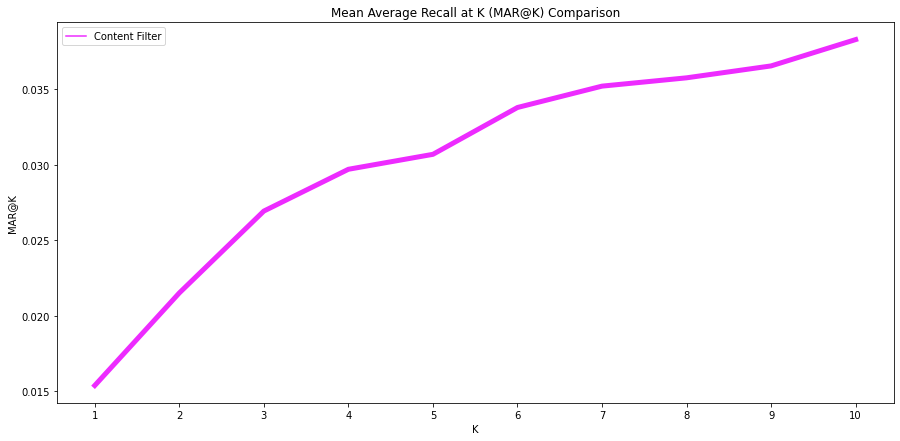

In [121]:
# generate a mark plot
mark_scores = [content_mark]
index = range(1,10+1)
names = ['Content Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

In [122]:
import ml_metrics as metrics

In [123]:
# for MAPK scpre
content_mapk = []
for K in np.arange(1, 11):
    content_mapk.extend([metrics.mapk(actual, content_predictions, k=K)])
content_mapk

[0.07920792079207921,
 0.05693069306930693,
 0.045104510451045104,
 0.040291529152915284,
 0.0364961496149615,
 0.03682618261826182,
 0.03631541725601131,
 0.03623438236680811,
 0.03680926624408472,
 0.038406259276721325]

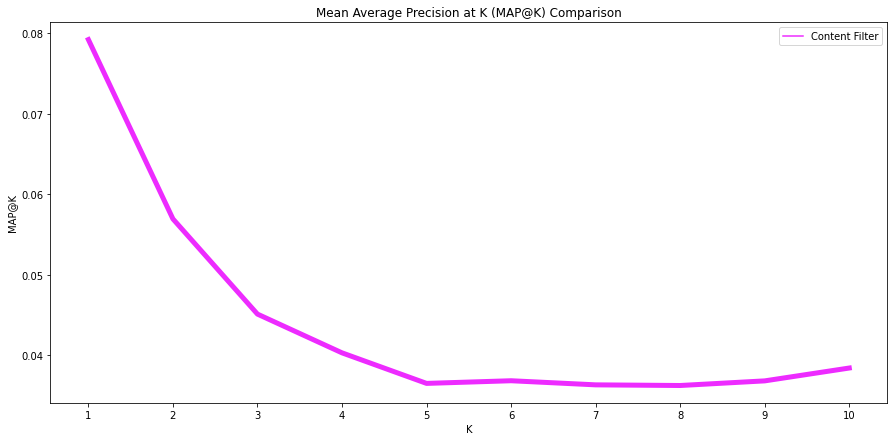

In [124]:
# generate a mapk plot
mapk_scores = [content_mapk]
index = range(1,10+1)
names = ['Content Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.mapk_plot(mapk_scores, model_names=names, k_range=index)

In [125]:
# prediction coverage
catalog = ratings.destination_id.unique().tolist()
content_coverage = recmetrics.prediction_coverage(content_predictions, catalog)

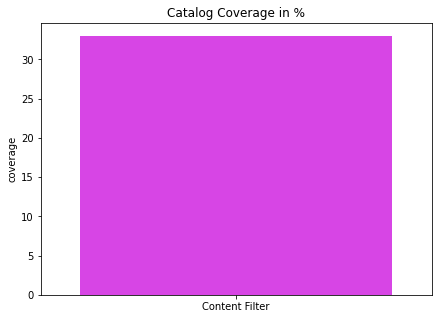

In [126]:
# plot of prediction coverage
coverage_scores = [content_coverage]
model_names = ['Content Filter']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

In [128]:
feature_df=destination_features[['history','art_and_architecture','nature','adventure', 'entertainment','health_and_lifestyle',\
                        'food','industries','religious']]
feature_df


,history,art_and_architecture,nature,adventure,entertainment,health_and_lifestyle,food,industries,religious
destination_id,,,,,,,,,
0,1,1,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
195,1,1,1,0,0,0,0,0,0
196,1,1,1,0,0,0,0,0,0
197,1,1,0,0,0,0,0,0,1


In [129]:
recmetrics.intra_list_similarity(content_predictions, feature_df)

0.9498550336850633